In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Times New Roman"]
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline
import tensorflow as tf
import torch
import torch.nn.functional as Func
import torch.nn as nn

# 一、背景介绍

&emsp;&emsp;2018年10月，Google发出一篇论文《BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding》, BERT模型横空出世, 并横扫NLP领域11项任务的最佳成绩，[点击下载论文](https://arxiv.org/pdf/1810.04805.pdf)。然而，在BERT中发挥重要作用的结构就是Transformer, 之后又相继出现XLNET，roBERT等模型击败了BERT，但是他们的核心没有变，仍然是：Transformer.

## 1.1 优势

&emsp;&emsp;相比之前通知市场的LSTM和GRU，Transformer用于两个显著的优势:

- Transformer可以利用分布式GPU进行并行训练，这可以大大提高模型的训练效率;
- 在分析预测更长的文本时，捕获间隔较长的语义关联效果更好;

<center><img src="images/优势.png"></center>

## 1.2 架构解析

&emsp;&emsp;基于seq2seq架构的transformer模型可以完成NLP领域研究的典型任务，如机器翻译，文本生成等，同时又可以构建预训练语言模型，用于不同任务的迁移学习。声明：在接下来的架构分析中，我们将假设使用Transformer模型架构处理从一种语言文本到另一种语言文本的翻译工作。因此，很多命名方式遵循NLP中的规则，如Embedding层将称为文本嵌入层，Embedding层产生的张量称为词嵌入张量，它的最后一维称为词向量等。Transformer由输入部分、输出部分、编码器部分和解码器部分组成，总体架构如下所示:

<center><img src="images/架构.png" style="zoom: 70%"></center>

# 二、逐一攻破

## 2.1 输入部分

- 源文本嵌入层和位置编码器;
- 目标文本嵌入层和位置编码器;

<center><img src="images/输入.png" style="zoom: 70%"></center>

### 2.1.1 自定义文本嵌入层

- 作用: 无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示，希望的在高维空间捕获词汇间的关系;

In [2]:
# 预定义的网络层torch.nn工具开发者已经帮助我们开发好了一些常用的层，如卷积层、lstm层和embedding层，我们更多需要关注如何使用好这些轮子，而不是重复造轮子;
import math
from torch.autograd import Variable
import torch.nn as nn

In [3]:
# 定义Embedding类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层，它们共享参数，该类继承自nn.Module，这样它就具备一些标准层的功能，这里我们也可以理解为一种模式;
# 测试torch自带的embedding层 ---> Lookup Table
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)  # num_embeddings表示文本中的词汇组成的词汇表中的最大idx,embedding_dim为每一个词向量的维度;
input_ = torch.LongTensor([[1, 2, 4, 5], 
                           [4, 3, 2, 9]])
res = embedding(input_)
print(res.size())
res

torch.Size([2, 4, 3])


tensor([[[-0.5409,  0.5733, -0.2060],
         [-0.5199, -0.9096,  0.8297],
         [ 0.7857, -1.4725,  0.8146],
         [ 0.8693,  0.5682, -0.0063]],

        [[ 0.7857, -1.4725,  0.8146],
         [ 0.8485, -0.3264, -0.1791],
         [-0.5199, -0.9096,  0.8297],
         [-0.0732, -0.3762,  0.3397]]], grad_fn=<EmbeddingBackward>)

<center><img src="images/输入架构.png"></center>

- 原始数据维度为: (2, 4)表示batch=2，每一条序列的长度为4, 其中每一个数字映射一个词汇，当然一个词汇也可以找到一个idx;
- embedding转换后维度为(2, 4, 3) -> 2表示batch, 其中input_中的每一元素都转换为一个长度为3的向量，不过这些数字的意义我们也不太清楚;

In [12]:
embedding2 = nn.Embedding(num_embeddings=10, embedding_dim=3)
sample = torch.LongTensor([[6, 4, 2, 9], 
                           [10, 12, 8, 1]])  # 注意输入中的idx不能超过num_beddings设置的数值(本例为10)，程序会报错;
embedding2(sample)

IndexError: index out of range in self

In [11]:
embedding3 = nn.Embedding(num_embeddings=10, embedding_dim=3, padding_idx=2)  # 将input中对应的idx全部置为0;
sample = torch.LongTensor([[1, 2, 0, 5]])
embedding3(sample)

tensor([[[ 0.7326, -1.9357,  1.6050],
         [ 0.0000,  0.0000,  0.0000],
         [ 1.1151,  1.3207,  1.7409],
         [ 0.2858, -1.3380, -0.8058]]], grad_fn=<EmbeddingBackward>)

In [28]:
class Embeddings(nn.Module):
    
    # 类初始化函数
    def __init__(self, vocab, d_model):
        """
        d_model: 词嵌入维度;
        vocab: 词汇表的大小;
        """
        super(Embeddings, self).__init__()  # 使用super()表明初始化函数继承自Embeddings;
        # 调用nn中的预定义层Embedding, 获得一个词嵌入对象;
        self.lut = nn.Embedding(num_embeddings=vocab, embedding_dim=d_model)
        self.d_model = d_model
    
    # 该层的前向传播逻辑，所有层中都会有此函数:  当外部传入给该类的实例对象参数时，torch会自动调用该实例方法；
    def forward(self, x):
        """
        x: 因为Embedding层是首层，所以代表输入给模型的文本通过词汇映射后的张量;
        """
        # 将x传给self.lut并与根号下self.d_model相乘(缩放功能, 控制数值大小)作为结果返回;
        return self.lut(x) * math.sqrt(self.d_model)

In [29]:
# 设置参数;
d_model = 512  # 词嵌入维度;
vocab = 1000  # 词汇表大小;
# 输入x是一个使用Variable封装的长整型变量，形状是2*4;
x = Variable(torch.LongTensor([[100, 2, 421, 508], 
                               [491, 998, 1, 221]]))
print("输入x的维度为:", x.shape)
x

输入x的维度为: torch.Size([2, 4])


tensor([[100,   2, 421, 508],
        [491, 998,   1, 221]])

In [30]:
# Embeddings类实例化;
emb = Embeddings(vocab, d_model)
# 对象调用;
embr = emb(x)
print("维度为:", embr.shape)
embr

维度为: torch.Size([2, 4, 512])


tensor([[[-17.2990,  14.1965, -32.0529,  ..., -22.3831, -13.2464,  14.1289],
         [-12.0476,  44.2968,   1.5094,  ...,   2.7186, -16.5343, -14.3205],
         [  6.7501, -21.1575,  10.7444,  ..., -17.6629,  20.7668,   8.0726],
         [ -4.4287, -27.2038,   0.7414,  ...,  11.9140, -12.7844,  -3.9581]],

        [[ -4.7024, -29.4047,  14.9030,  ...,  -0.1109,  23.4812,  37.1878],
         [ -4.8218,  25.1742, -15.8650,  ...,  25.6967,  18.8379,   7.8923],
         [-38.0939,  -6.6169,  12.0502,  ...,   7.0672,  -6.9286,  24.4094],
         [ -6.0510, -19.2547, -22.9137,  ..., -20.5898, -17.2267,  -1.1193]]],
       grad_fn=<MulBackward0>)

### 2.1.2 位置编码器

- 作用: 在Transformer编码器结构中，并没有针对词汇位置信息的处理，因此需要在Embedding层中加入位置编码器，将词汇优于位置不同可能会产生不同语义的信息加入到词嵌入张量中，以弥补位置信息的缺失，如"我爱中国"和"中国爱我"。

In [38]:
x = torch.tensor([1, 2, 3, 4])
print("原始数据维度为:", x.shape, x)

x_2 = x.unsqueeze(0)  # 也可以使用torch.unsqueeze(x, 0)
print("升一维后的维度为:", x_2.shape, x_2)

x_3 = torch.unsqueeze(, dim=1)  # 也可以使用torch.unsqueeze(x, 0)
print("升一维后的维度为:", x_3.shape, x_3)

原始数据维度为: torch.Size([4]) tensor([1, 2, 3, 4])
升一维后的维度为: torch.Size([1, 4]) tensor([[1, 2, 3, 4]])
升一维后的维度为: torch.Size([4, 1]) tensor([[1],
        [2],
        [3],
        [4]])


In [37]:
m = nn.Dropout(0.2)  # p随机失活率;
sample3 = torch.randn(4, 5)
m(sample3)

tensor([[-0.4709,  0.0044,  1.1978, -0.0640,  1.3698],
        [-1.7737, -0.0000,  0.0980,  0.2306, -1.5674],
        [ 1.0680,  0.6984, -0.0000,  1.0395, -1.4948],
        [-0.4038,  0.3801,  0.0000,  0.8346,  1.2462]])

**分析:** 
- 词嵌入文本组成的特征矩阵 + 位置矩阵 --> 可获得带有位置信息的词嵌入文本，而特征矩阵可通过Embeddings获得，那么我们的重心就是如何计算位置矩阵;
- 位置矩阵要与特征矩阵进行对应元素(element-wise)的相加，那么它们的维度(max_len, dim)肯定是相同的 --> 位置编码矩阵pe = torch.zeors(max_len, dim);
- 既然是位置矩阵，那么我们首先需要获得每一个词汇的绝对位置，本文使用索引(连续自然数向量)来对其进行表示 --> position = torch.arange(0, max_len).unsqueeze(1) --> position维度(max_len, 1)
- 绝对位置矩阵初始化后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵pe中?
- 绝对位置矩阵position的维度为(max_len, 1)，而位置编码矩阵的维度为(max_len, dim)，很明显我们需要一个维度为(1, dim)的变换矩阵div_term；
- 变换矩阵div_term除了形状必须满足(1, dim)外，我们还希望它可以将自然数的绝对位置编码pe缩放成足够小的数字，有助于后面梯度下降过程下降的更快;

<center><img src="images/位置编码.png" style="zoom: 70%"></center>

In [391]:
class PositionalEncoding(nn.Module):
    
    # 位置编码器初始化函数;
    def __init__(self, d_model, dropout, max_len=5000):  # 下面演示序列最大长度max_len=60, d_model=512
        """
        d_model: 词嵌入维度;
        dropout: 置0比率;
        max_len: 每个序列(句子)的最大长度;
        """
        super(PositionalEncoding, self).__init__()
        # 1.先实例化一个nn中预定义的Dropout层，并将dropout传入其中，获得对象self.dropout;
        self.dropout = nn.Dropout(p=dropout)
        
        # 2. 初始化一个位置编码矩阵(positional encoding)，它的维度为(max_len, d_model);
        pe = torch.zeros(max_len, d_model)  # (60, 512)
        
        # 3. 初始化一个绝对位置矩阵，它的维度为(max_len, )，其中unsqueeze(1)是为了将其升维(max_len, 1);
        position = torch.arange(0, max_len).unsqueeze(1)  # (60, 1)
        
        # 4. 初始化变换矩阵: 自然数矩阵(step=2)*缩放系数
        """
        - 这里并没有直接按照之前分析的那样初始化了一个(1, d_model)的矩阵，而是有了一个跳跃，即只初始化了一半(1, d_model/2=256)的矩阵，为什么是一半呢?
        - 其实，这里并不是真正意义上的初始化了一半的矩阵，而是可以将其看作是初始化了2次，而每次初始化的变换矩阵会做不同的处理;
        - 第一次初始化的变换矩阵分布在正弦波上，第二次初始化的变换矩阵分布在余弦波上，并且把这两个矩阵分别填充在位置编码矩阵的偶数和奇数位置上，形成最终的位置编码矩阵;
        """
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))  # (1, (end-start)/step=256)
        pe[:, 0::2] = torch.sin(position * div_term)  # (60, 256)  --> 给每一个词汇的偶数列增加sin(位置编码信息);
        pe[:, 1::2] = torch.cos(position * div_term)  # (60, 256)  --> 给每一个词汇的奇数列增加cos(位置编码信息);
        pe = pe.unsqueeze(0)  # 为了将pe与embeddding进行相加，还需要将pe进行升维(初始为二维);
        
        # 5. 最后，将pe位置编码矩阵注册成模型的buffer，什么是buffer呢?
        """
        - 我们可以将其看作是对模型有帮助，但却不是模型结构中的参数或超参数，不需要随着优化步骤进行更新的增益对象;
        - 注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载，类似于向模块添加持久缓冲区，并且缓冲区使用给定的名称作为属性访问;
        """
        self.register_buffer("pe", pe)
    
    # 前向传播逻辑;
    def forward(self, x):  # x为文本序列的词嵌入表示(2, 4, 512)
        """
        pe: (1, max_len, d_model) --> (1, 5000, 512)
        - 在将位置编码矩阵pe和词嵌入特征矩阵进行相加前，我们还需要对pe做一些适配工作,将pe的第二维max_len切片至与输入的x第二维相同即可;
        - 位置编码矩阵本质上相当于我们提前做了一个很大的【位置编码表】，而它使用的max_len实际中很少有一个句子可以包含5000个词汇，所以要与输入张量进行适配;
        - 最后使用Variable对其进行封装，使它与x的样式相同，但是它是不需要进行梯度求解的，所以要把requires_grad设置为False;
        """
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [392]:
# 实例化参数;
dropout = 0.1
max_len = 60
print("词嵌入维度为:", d_model)

词嵌入维度为: 512


In [393]:
print("词嵌入维度为:", embr.shape)
embr

词嵌入维度为: torch.Size([2, 4, 512])


tensor([[[-17.2990,  17.1965, -32.0529,  ..., -19.3831, -13.2464,  17.1289],
         [ -9.5232,  45.9177,   3.9750,  ...,   5.7186, -16.5340, -11.3205],
         [  9.4780, -22.4059,  13.5536,  ..., -14.6629,  20.7674,  11.0726],
         [ -4.0054, -30.1738,   1.4766,  ...,  14.9140, -12.7834,  -0.9581]],

        [[ -4.7024, -26.4047,  14.9030,  ...,   2.8891,  23.4812,  40.1878],
         [ -2.2974,  26.7951, -13.3995,  ...,  28.6967,  18.8382,  10.8923],
         [-35.3660,  -7.8654,  14.8594,  ...,  10.0672,  -6.9280,  27.4094],
         [ -5.6277, -22.2247, -22.1785,  ..., -17.5898, -17.2257,   1.8807]]],
       grad_fn=<AddBackward0>)

In [394]:
# 位置编码类实例化对象;
pe = PositionalEncoding(d_model, dropout, max_len=max_len)
x = embr
pe_result = pe(x)
print("位置编码后维度为:", pe_result.size())
pe_result

位置编码后维度为: torch.Size([2, 4, 512])


tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<MulBackward0>)

**绘制词汇向量中特征的分布曲线:**

In [395]:
dim = 20
pe_test = PositionalEncoding(d_model=dim, dropout=0)
y = pe_test(Variable(torch.zeros(1, 100, dim)))  # x为全0，相当于编码后的结果就是pe;
y.shape

torch.Size([1, 100, 20])

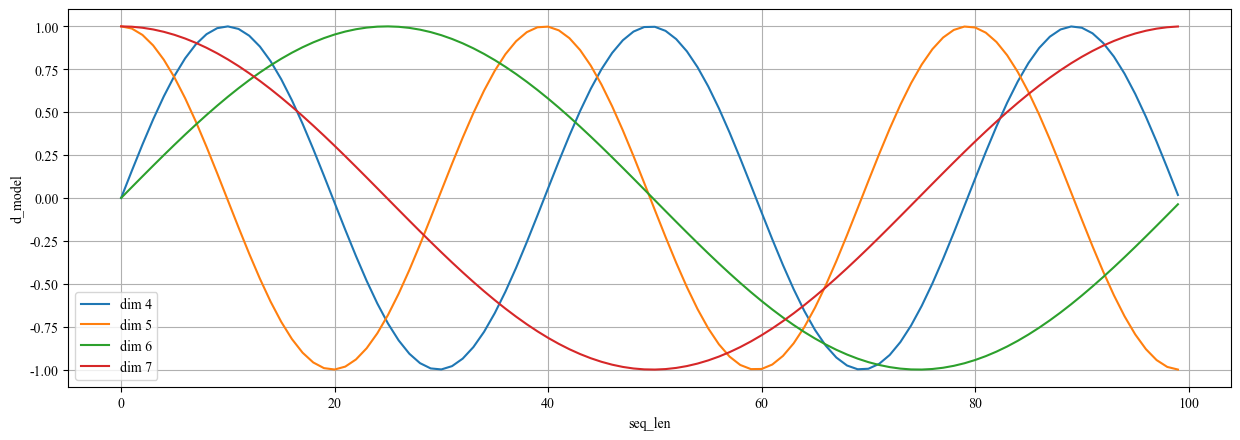

In [396]:
plt.figure(dpi= 100, figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())  # pe总共有20维，我们这里只展示4-7维;
plt.legend(["dim %d" % p for p in np.arange(4, 8)])  
plt.xlabel("seq_len")
plt.ylabel("d_model")
plt.grid()
plt.show()

**效果分析:**

- 每条颜色的曲线代表某一个词汇中的特征在不同位置的含义;
- 保证同一词汇随着所在位置不同它对应位置嵌入向量会发生变化;
- 正弦波和预先波的值域范围都是-1到1，这又很好地控制了嵌入数值的大小，有助于梯度的快速计算;

## 2.2 编码器部分

<center><img src="images/编码器.png"></center>

- 由N个编码器层堆叠二层，并且每个编码器层由2个子层连接结构组成;
- 第一个子层连接结构由一个多头自注意力子层、规范层和一个残差连接组成;
- 第二个子层连接结构包括一个前馈全连接子层、规范层以及一个残差连接组成;

### 2.2.1 掩码张量

&emsp;&emsp;**什么是掩码张量：**

&emsp;&emsp;掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面的元素一般只有0和1，代表位置不被遮掩或被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩，也可以说被替换，它的表现形式是一个张量;


&emsp;&emsp;**掩码张量的作用：**

&emsp;&emsp;在Transformer中，掩码张量的主要作用在应用attention(注意力机制)，有一些生成的attention张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时把整个输出结果都一次性进行Embedding, 但是理论上解码器的输出却不是一次就能产生最终结果的 ，而是一次次通过上次结果综合得出的，因此，未来的信息可能被提前利用，所以，我们会对其进行遮掩;

In [397]:
data = np.arange(1, 17).reshape(4, 4)
# np.triu: 上三角矩阵(0整体方向朝上, 即逐层递增) --> np.tril()下三角矩阵;
np.triu(data, k=0)  # k=0表示对角线以下置为上三角矩阵, k=-1表示对角线下一层, k=1表示对角线以上;

array([[ 1,  2,  3,  4],
       [ 0,  6,  7,  8],
       [ 0,  0, 11, 12],
       [ 0,  0,  0, 16]])

In [398]:
np.triu(data, k=-1)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 0, 10, 11, 12],
       [ 0,  0, 15, 16]])

In [399]:
np.triu(data, k=1)

array([[ 0,  2,  3,  4],
       [ 0,  0,  7,  8],
       [ 0,  0,  0, 12],
       [ 0,  0,  0,  0]])

In [400]:
# 下三角矩阵: 
np.tril(data, k=0)

array([[ 1,  0,  0,  0],
       [ 5,  6,  0,  0],
       [ 9, 10, 11,  0],
       [13, 14, 15, 16]])

In [401]:
np.tril(data, k=-1)

array([[ 0,  0,  0,  0],
       [ 5,  0,  0,  0],
       [ 9, 10,  0,  0],
       [13, 14, 15,  0]])

In [402]:
np.tril(data, k=1)

array([[ 1,  2,  0,  0],
       [ 5,  6,  7,  0],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [403]:
temp = np.triu(np.ones(shape=(4, 4)), k=1)
temp

array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [404]:
1 - temp

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [405]:
# 生成掩码张量的代码分析;
def subsequent_mask(size):  # 参数size表示掩码张量最后两维的大小，它的最后两维形成一个方阵;
    # 首先定义掩码张量的形状;
    attn_shape = (1, size, size)
    
    # 然后使用np.ones()方法向这个形状中添加1元素，形成上三角矩阵，最后为节约空间再使其中的数据类型变为无符号8位整形uint8;
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype("uint8")
    
    # 最后将numpy类型转为torch中的tensor类型，内部做一个1-操作将上三角矩阵转为下三角矩阵: 防止未来信息被提前使用;
    return torch.from_numpy(1 - subsequent_mask)

In [406]:
# 生成的掩码张量最后两维大小
size = 5
sm = subsequent_mask(size)
sm

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

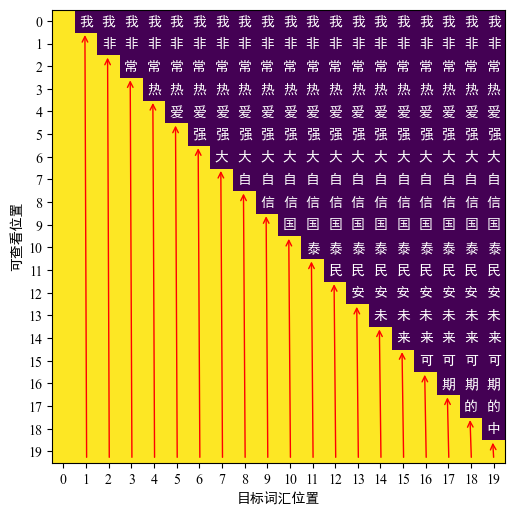

In [407]:
# 我们将进行可视化展示;
target = "我非常热爱强大自信国泰民安未来可期的中国"  # 20--> 0、1、...、19
plt.figure(dpi=100, figsize=(6, 6))
plt.imshow(subsequent_mask(20)[0])
plt.xlabel("目标词汇位置", fontdict=dict(family="SimHei"))
plt.ylabel("可查看位置", fontdict={"family": "SimHei"})
plt.yticks(range(0, 20))
plt.xticks(range(0, 20))
# 将目标文本展示在上述方阵中;
for x in range(0, 19):
    for y in range(x+1, 20):
        plt.text(y, x, target[x], fontdict={"color": "white", "family": "SimHei"}, ha="center", va="center")
    plt.annotate(text=" ", xy=(x+0.95,x+0.5), xytext=(x+0.95, 20), arrowprops=dict(arrowstyle="->", color="red"))  # xy表示text的终点坐标，xytext表示text的起点坐标;
plt.show()

**观察分析:**

- 上述方阵，黄色是1的部分，表示被遮掩，紫色代表没有被遮掩的信息，横坐标代表目标词汇的位置，纵坐标表示可查看的位置;
- 可以看到: 在0位置，一眼望去都是黄色，而1的位置只能看到一个信息，并且该信息是前一次的信息，而其它位置的信息也看不到;

### 2.2.2 注意力机制

**什么是注意力:** 
- 我们观察事物时，之所以能够快速判断一种事物，是因为我们的大脑能够很快把注意力放在事物最具有辨识度的部分，而并非是从头到尾观察一遍事物后，才能有判断结果。基于这样的理论，就产生了注意力机制.

**注意力计算规则:** 
- 需要三个指定的输入Q(query), K(key), V(value), 然后通过公式得到注意力的计算结果, 这个结果代表query在key和value作用下的表示. 而这个具体的计算规则有很多种, 我们这里只介绍一种;

$$\text{Attention} = \text{Softmax}(\frac{Q·K^T}{\sqrt{d_k}})·V$$

**Q、K和V的形象比喻:** 假如我们有一个问题: 给出一段文本，使用一些关键词对它进行描述!

- 为了方便统一正确答案，这道题可能预先已经给大家写出了一些关键词作为提示,其中这些给出的提示就可以看作是key, 而整个的文本信息就相当于是query, value的含义则更抽象，可以比作是你看到这段文本信息后，脑子里浮现的答案信息。
- 这里我们又假设大家最开始都不是很聪明，第一次看到这段文本后脑子里基本上浮现的信息就只有提示这些信息，因此key与value基本是相同的，但是随着我们对这个问题的深入理解，通过我们的思考脑子里想起来的东西原来越多，并且能够开始对我们query也就是这段文本，提取关键信息进行表示，这就是注意力作用的过程，通过这个过程，我们最终脑子里的value发生了变化，根据提示key生成了query的关键词表示方法，是另外一种特征表示方法.
- 刚刚我们说到key和value一般情况下默认是相同，与query是不同的，这种是我们一般的注意力输入形式；
- 但有一种特殊情况，就是我们query与key和value相同，这种情况我们称为自注意力机制，就如同我们的刚刚的例子，使用一般注意力机制，是使用不同于给定文本的关键词表示它. 而<font color="red">自注意力机制</font>，需要用给定文本自身来表达自己，也就是说你<font color="red">需要从给定文本中抽取关键词来表述它, 相当于对文本自身的一次特征提取</font>。

**注意力机制:** 

- 注意力计算规则能够应用到深度学习网络的载体，除注意力计算规则外，还包括一些必要的全连接层以及相关张量处理，使其与应用网络可以融为一体，使用自注意力计算规则的注意力机制为自注意力机制;

<center><img src="images/自注意机制.png"></center>

In [408]:
sample = Variable(torch.randn(5, 5))
sample

tensor([[ 0.2195, -0.9799, -0.2886,  1.1617,  0.7854],
        [-0.4930, -1.1410, -0.5205,  0.1431,  0.7478],
        [-0.5227, -1.1205, -0.4824,  0.9985,  1.8936],
        [ 0.3613,  1.2409,  0.2907, -1.1920, -0.3815],
        [-1.2226, -0.0873, -0.5108, -0.0287, -0.9502]])

In [409]:
mask = Variable(torch.zeros(5, 5))
mask[0][0] = 1
mask

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [410]:
sample.masked_fill(mask == 0, value=-1e9)  # mask[0][0]处不是0，所以不进行填充;

tensor([[ 2.1947e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [411]:
# 注意力机制实现;
def attention(query, key, value, mask=None, dropout=None):
    """
    query: 查询张量，一段准备被概括的文本; key: 键张量，给出的提示; value: 值张量，大脑对提示k的延申;
    mask: 掩码张量; dropout: nn.Dropout层的实例对象，默认为None
    """
    # 1.函数中，首先获取query的最后一维大小，一般情况下等同于我们的词嵌入维度, 即d_k;
    d_k = query.size(-1)
    
    # 2.按照注意力公式，将query与key的转置相乘，这里面key将最后两个维度进行转置，再除以缩放系数根号下的d_k, 这种计算方法也称为缩放点积注意力计算;
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # (2, 4, 512) * (2, 512, 4) --> (2, 4, 4)【query四个单词，key四个单词，需要计算它们的相似度，不转置无法计算】
    
    # 3.接着判断是否使用掩码张量;
    if mask is not None:
        # 使用tensor的masked_fill方法，将掩码张量和scores张量每个位置一一比较，如果掩码张量处为0，额对应的scores张量用-1e9这个值进行替换;
        scores = scores.masked_fill(mask==0, -1e9)
    
    # 4. 对scores的最后一维进行softmax操作，使用Func.softmax()方法，第一个参数为softmax对象，第二个参数为目标维度 --> 注意力张量;
    p_attn = Func.softmax(scores, dim=-1)
    
    # 5. 判断是否使用dropout进行随机置0;
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn, scores  # 以元组打包返回，第一个参数为query的注意力表示，第二个参数为注意力张量;

In [412]:
print("位置编码矩阵维度为:", pe_result.size())
pe_result

位置编码矩阵维度为: torch.Size([2, 4, 512])


tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<MulBackward0>)

In [413]:
query = key = value = pe_result

**无mask的输入：**

In [414]:
attn, p_attn, scores_no_mask = attention(query, key, value)

In [415]:
print("query的注意力表示attn的维度为:", attn.shape)
attn

query的注意力表示attn的维度为: torch.Size([2, 4, 512])


tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ...,  0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00,  0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<UnsafeViewBackward>)

In [416]:
print("注意力张量的维度为:", p_attn.shape)
p_attn

注意力张量的维度为: torch.Size([2, 4, 4])


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward>)

**有mask的输入:**

In [417]:
mask = Variable(torch.zeros(2, 4, 4))

In [418]:
attn2, p_attn2, scores_with_mask = attention(query, key, value, mask=mask)

In [419]:
print("query的注意力表示attn2维度为:", attn2.size())
attn2

query的注意力表示attn2维度为: torch.Size([2, 4, 512])


tensor([[[ -5.4049,   2.9635,  -3.0679,  ...,  -1.9290,  -6.0544,   0.4983],
         [ -5.4049,   2.9635,  -3.0679,  ...,  -1.9290,  -6.0544,   0.4983],
         [ -5.4049,   2.9635,  -3.0679,  ...,  -1.9290,  -6.0544,   0.4983],
         [ -5.4049,   2.9635,  -3.0679,  ...,  -1.9290,  -6.0544,   0.4983]],

        [[-12.8060,  -1.7641,  -1.0589,  ...,   7.7954,  -1.4764,  11.1949],
         [-12.8060,  -1.7641,  -1.0589,  ...,   7.7954,  -1.4764,  11.1949],
         [-12.8060,  -1.7641,  -1.0589,  ...,   7.7954,  -1.4764,  11.1949],
         [-12.8060,  -1.7641,  -1.0589,  ...,   7.7954,  -1.4764,  11.1949]]],
       grad_fn=<UnsafeViewBackward>)

In [420]:
print("注意力权重系数p_attn2的维度为:", p_attn2.shape)
p_attn2

注意力权重系数p_attn2的维度为: torch.Size([2, 4, 4])


tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]]], grad_fn=<SoftmaxBackward>)

**结论:**  $Q·K^T$本质上可以理解为求目标文本和源文本的相似度，形式上类似于皮尔逊相关系数或协方差矩阵
- 注意力权重scores如果不加mask的话，第一个单词和第一个单词的相似度最高，自然得分最高，出现单位矩阵;
- 如果注意力权重scores加了mask的话，softmax后权重是均匀分布的;

In [421]:
scores_no_mask

tensor([[[13371.8896,   783.1205,   190.6888,    84.3016],
         [  783.1205, 13233.7881,  -238.9447,  -285.4847],
         [  190.6888,  -238.9447, 13383.8408,   338.2499],
         [   84.3016,  -285.4847,   338.2499, 12662.7344]],

        [[13635.4414,  -284.1069,  -114.2562,  -118.6423],
         [ -284.1069, 12649.9473,    49.8709,   186.2396],
         [ -114.2562,    49.8709, 13526.9111,  -560.4368],
         [ -118.6423,   186.2396,  -560.4368, 12805.1074]]],
       grad_fn=<DivBackward0>)

In [422]:
scores_no_mask

tensor([[[13371.8896,   783.1205,   190.6888,    84.3016],
         [  783.1205, 13233.7881,  -238.9447,  -285.4847],
         [  190.6888,  -238.9447, 13383.8408,   338.2499],
         [   84.3016,  -285.4847,   338.2499, 12662.7344]],

        [[13635.4414,  -284.1069,  -114.2562,  -118.6423],
         [ -284.1069, 12649.9473,    49.8709,   186.2396],
         [ -114.2562,    49.8709, 13526.9111,  -560.4368],
         [ -118.6423,   186.2396,  -560.4368, 12805.1074]]],
       grad_fn=<DivBackward0>)

In [423]:
Func.softmax(scores_no_mask, dim=-1)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward>)

In [424]:
scores_with_mask

tensor([[[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]],

        [[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]]],
       grad_fn=<MaskedFillBackward0>)

In [425]:
Func.softmax(scores_with_mask, dim=-1)

tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]]], grad_fn=<SoftmaxBackward>)

- 显然，模型初始化注意力张量都为$\frac{1}{4}$，然后根据模型的预测值和样本真实值计算损失值，利用BP算法误差反向传播更新权重系数，相似度较高者权重增大，反之降低;[Softmax详解](https://www.cnblogs.com/alexanderkun/p/8098781.html)

### 2.2.3 多头注意力机制

- 从多个角度取提取事物的特征，即每个头都想获得一组Q、K和V进行注意力机制计算，所以它主要作用于词嵌入向量的最后一维(d_model，本文为512)，将每个头获得的输入送至注意力机制中就形成多头注意力机制;
- 这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以提升模型效果;

<center><img src="images/多头注意力.png" style="zoom: 70%">

**view()和transpose对比:**

In [426]:
data = torch.arange(8).reshape(2, 2, 2)  # 2个矩阵组成，每个矩阵的维度为2*2;
print("data的维度为:", data.shape)
data

data的维度为: torch.Size([2, 2, 2])


tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

In [427]:
data.transpose(0, 1)

tensor([[[0, 1],
         [4, 5]],

        [[2, 3],
         [6, 7]]])

In [428]:
print("位置编码维度为:", pe_result.shape)
pe_result

位置编码维度为: torch.Size([2, 4, 512])


tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<MulBackward0>)

In [429]:
# 使用reshape进行编码: 先进行三维扩展四维，并交换1、2维;
multi = pe_result.reshape(2, 4, 8, 64).transpose(1, 2)
multi.shape

torch.Size([2, 8, 4, 64])

In [430]:
multi.transpose(1, 2).reshape(2, -1, 512)

tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<ViewBackward>)

In [431]:
multi.transpose(1, 2).view(2, -1, 512)

tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<ViewBackward>)

In [432]:
multi.transpose(1, 2).contiguous().view(2, -1, 512)

tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<ViewBackward>)

**多头注意力代码实现：**

In [433]:
# 先导入用于深度拷贝的工具包；
from copy import deepcopy

# 定义一个克隆函数，因为再多头注意力机制的实现中，用到多个结构相同的线性层;
def clones(module, N):  # 使用clones函数将它们一同初始化在一个网络层列表对象中，之后的结构也会用到该函数;
    """
    module: 要克隆的目标网络层;
    N: 需要克隆的数量;
    """
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [434]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, head, embedding_dim, dropout=0.1):
        """
        head: 代表头数;
        embedding_dim: 词嵌入维度;
        dropout: 进行Dropout操作时置0比率，默认为0.1;
        """
        super(MultiHeadedAttention, self).__init__()
        
        # 1.首先使用assert语句判断head能否被d_model整除，这是因为我们之后要为每个头分配等量的词特征，也就是embedding_dim / head(结果为浮点数);
        assert embedding_dim % head == 0
        self.d_k = embedding_dim // head  # 获得每个头的词向量维度d_k;
        self.head = head
        
        # 2. 获得线性层对象，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim * embedding_dim，然后使用clones克隆4个(多头注意力中Q、K和C各需1个，最后拼接还需要1个);
        self.linears = clones(nn.Linear(in_features=embedding_dim, out_features=embedding_dim), 4)
        self.attn = None  # 它代表最后的注意力张量，现在还没有结果所以为None
        
        # 3. 最后设置self.dropout对象，通过nn.Dropout()实例化而来，置0比率为传进来的参数dropout;
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        # 1.如果掩码张量mask存在;
        if mask is not None:
            mask = mask.unsqueeze(0)  # 维度扩展;
        
        # 获得样本数(batch_size)，如(2, 4, 512)
        batch_size = query.size(0)
        
        # 2.多头处理环节: (2, 4, 512) --> (2, 4, 8, 64)【8个头,每个头64个词向量】 --> (2, 8, 4, 64)【交换head和seq_len，让seq_len与d_model相邻，以捕捉句子特征】;
        # attention可以知道, q·k -> 权重系数`V --> Q有8个头、K有8个头、V有8个头，这24个头一块进入attention，内部通过矩阵进行并行计算，返回注意力机制atten和注意力权重p_atten;
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2) for model, x in zip(self.linears, (query, key, value))]  # view相当于reshape(三维扩四维);
        
        # 3.得到每个头的输入后，接下里就是将它们传入到attention中，直接调用之前定义好的attention函数，同时也将mask和dropout传入其中;
        x, self.attn, _ = attention(query, key, value, mask, dropout=self.dropout)  # 注意力机制x形状(2, 8, 4, 64)和注意力权重self.attn形状(1, 8, 4, 4) 
        
        # 4.形状变化: 注意力机制x的维度(2, 8, 4, 64)  --> (2, 4, 8, 64)【这步感觉多此一举】 --> (2, 4, 512)【四维转三维，将每个注意力机制的结果进行concat】;
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head*self.d_k)  # 使用transpose后导致Tensor内存不连续，需要先使用contiguous()后才能调用view();
        return self.linears[-1](x)  # 使用线性层linears中的最后一个线性层对输入进行线性变换得到最终的多头注意结构输出;

In [435]:
pe_result

tensor([[[-1.9221e+01,  2.0218e+01, -3.5614e+01,  ..., -0.0000e+00,
          -1.4718e+01,  0.0000e+00],
         [-9.6464e+00,  5.1620e+01,  5.3298e+00,  ...,  7.4651e+00,
          -1.8371e+01, -1.1467e+01],
         [ 1.1541e+01, -2.5358e+01,  1.6100e+01,  ..., -1.5181e+01,
           2.3075e+01,  1.3414e+01],
         [-4.2936e+00, -3.4626e+01,  1.9130e+00,  ...,  0.0000e+00,
          -1.4203e+01,  4.6532e-02]],

        [[-5.2249e+00, -2.8227e+01,  1.6559e+01,  ...,  4.3212e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6177e+00,  3.0373e+01, -1.3975e+01,  ...,  3.2996e+01,
           2.0931e+01,  1.3214e+01],
         [-3.8285e+01, -9.2017e+00,  1.7551e+01,  ...,  1.2297e+01,
          -7.6976e+00,  3.1566e+01],
         [-6.0962e+00, -0.0000e+00, -2.4370e+01,  ..., -1.8433e+01,
          -1.9139e+01,  0.0000e+00]]], grad_fn=<MulBackward0>)

In [436]:
head = 8
embedding_dim = 512
dropout = 0.2
query = key = value = pe_result

In [437]:
mask = Variable(torch.zeros(8, 4, 4))
mask.size()

torch.Size([8, 4, 4])

In [438]:
mha = MultiHeadedAttention(head, embedding_dim, dropout=dropout)
mha_res = mha(query, key, value, mask)
mha_res

tensor([[[ 4.5454e+00,  1.4785e+00,  2.0292e-01,  ..., -4.6643e+00,
          -1.8024e-01,  5.0463e+00],
         [ 7.0716e+00, -1.3778e+00, -7.3712e-01,  ..., -2.9570e+00,
           1.8880e+00,  6.4102e+00],
         [ 6.8207e+00,  3.1957e+00,  3.4607e+00,  ..., -1.9079e+00,
           1.3916e+00,  3.8457e+00],
         [ 3.8134e+00, -2.5439e+00, -1.1837e-01,  ..., -4.5817e-01,
           5.7996e+00,  2.8409e+00]],

        [[ 1.4176e+00, -2.7654e-01,  1.6552e+00,  ...,  2.1283e+00,
           8.0450e+00,  8.1718e+00],
         [ 2.4917e+00, -2.5911e+00, -5.1180e-01,  ...,  3.1481e+00,
           6.4397e+00,  6.0377e+00],
         [-3.6229e+00, -1.8522e+00, -1.9622e-02,  ..., -9.9256e-01,
           7.8289e+00,  5.2802e+00],
         [-6.3364e-03, -1.3188e+00, -5.1163e-01,  ..., -1.1694e+00,
           5.3540e+00,  3.8013e+00]]], grad_fn=<AddBackward0>)

### 2.2.4 前馈全连接层

- 在Transformer中，前馈全连接层就是具有两层线性层的全练级网络，考虑注意力机制可能对特征提取不够充分，增加两层网络来增强模型的拟合能力;
- relu激活函数: max(0, x), 优点为x>0时梯度下降快(导数为1)，缺点是当x<0时可能存在大量神经元死亡，进而引起模型欠拟合，改进一般使用LeakyRelu, max(0.2x, x);

<center><img src="images/relu.png"/ style="zoom: 70%"></center>

In [439]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        d_model: 词嵌入维度，它是第一个线性层的输入，同时也是第二个线性层的输出，即我们希望输入通过前馈前连接层后输入和输出维度不变;
        d_ff: 线性变换维度，它是第二个线性层的输入，同时也是第一个线性层的输入;
        dropout: 置0比率;
        """
        super(PositionwiseFeedForward, self).__init__()
        
        # 首先实例化两个线性层对象;
        self.w1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.w2 = nn.Linear(in_features=d_ff, out_features=d_model)
        # 使用nn.Dropout()实例化对象self.dropout;
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        x: 代表上一层的输出，编码器中为【多头注意力机制】，解码器中为【?】;
        """
        # 输出为经过两层线性网络变换的特征表示;
        return self.w2(self.dropout(Func.relu(self.w1(x))))  # 多头注意力机制 -> 第一层全连接神经网络(w1, 线性求和+激活函数-relu) -> Dropout(随机失活, 单独一层) -> 第二层全连接神经网络(w2);

In [440]:
d_model= 512
d_ff= 64
dropout = 0.2

In [441]:
print("多头注意力机制维度为:", mha_res.shape)
x = mha_res
x

多头注意力机制维度为: torch.Size([2, 4, 512])


tensor([[[ 4.5454e+00,  1.4785e+00,  2.0292e-01,  ..., -4.6643e+00,
          -1.8024e-01,  5.0463e+00],
         [ 7.0716e+00, -1.3778e+00, -7.3712e-01,  ..., -2.9570e+00,
           1.8880e+00,  6.4102e+00],
         [ 6.8207e+00,  3.1957e+00,  3.4607e+00,  ..., -1.9079e+00,
           1.3916e+00,  3.8457e+00],
         [ 3.8134e+00, -2.5439e+00, -1.1837e-01,  ..., -4.5817e-01,
           5.7996e+00,  2.8409e+00]],

        [[ 1.4176e+00, -2.7654e-01,  1.6552e+00,  ...,  2.1283e+00,
           8.0450e+00,  8.1718e+00],
         [ 2.4917e+00, -2.5911e+00, -5.1180e-01,  ...,  3.1481e+00,
           6.4397e+00,  6.0377e+00],
         [-3.6229e+00, -1.8522e+00, -1.9622e-02,  ..., -9.9256e-01,
           7.8289e+00,  5.2802e+00],
         [-6.3364e-03, -1.3188e+00, -5.1163e-01,  ..., -1.1694e+00,
           5.3540e+00,  3.8013e+00]]], grad_fn=<AddBackward0>)

In [442]:
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
# 多头注意力机制的输出作为前馈全连接神经网络的输入;
ff_res = ff(x)
ff_res

tensor([[[ 0.0723, -1.3044,  1.0354,  ..., -0.3223,  0.4824, -0.7122],
         [ 1.0235, -1.3052,  0.0929,  ...,  0.2794,  0.3948, -1.1433],
         [ 0.1457, -1.2966, -0.2368,  ...,  0.5628,  0.1130, -2.1850],
         [ 0.0122, -0.4525,  0.8617,  ..., -1.4876, -0.0861, -0.9704]],

        [[-0.2309,  0.8554, -0.7055,  ...,  0.0381,  1.9542, -1.1616],
         [-1.6203,  1.2558, -0.5508,  ..., -0.2630,  0.4384, -1.1096],
         [-0.5554, -0.0162, -0.4471,  ..., -0.8670,  0.1153, -0.3344],
         [-0.3050, -0.2370, -1.1100,  ...,  0.7357, -0.1435,  0.6275]]],
       grad_fn=<AddBackward0>)

### 2.2.5 规范化层

- 随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内;
- [数值标准化](https://blog.csdn.net/Orange_Spotty_Cat/article/details/80312154)
- [keepdim资料](https://blog.csdn.net/qq_36810398/article/details/104845401)

In [443]:
# 获取上一层(这里为前馈全连接层)的结果;
ff_res

tensor([[[ 0.0723, -1.3044,  1.0354,  ..., -0.3223,  0.4824, -0.7122],
         [ 1.0235, -1.3052,  0.0929,  ...,  0.2794,  0.3948, -1.1433],
         [ 0.1457, -1.2966, -0.2368,  ...,  0.5628,  0.1130, -2.1850],
         [ 0.0122, -0.4525,  0.8617,  ..., -1.4876, -0.0861, -0.9704]],

        [[-0.2309,  0.8554, -0.7055,  ...,  0.0381,  1.9542, -1.1616],
         [-1.6203,  1.2558, -0.5508,  ..., -0.2630,  0.4384, -1.1096],
         [-0.5554, -0.0162, -0.4471,  ..., -0.8670,  0.1153, -0.3344],
         [-0.3050, -0.2370, -1.1100,  ...,  0.7357, -0.1435,  0.6275]]],
       grad_fn=<AddBackward0>)

In [444]:
ff_res.mean(dim=-1)

tensor([[ 0.0131,  0.0210, -0.0168, -0.0152],
        [-0.0563, -0.0539, -0.0053, -0.0527]], grad_fn=<MeanBackward1>)

In [445]:
mean = torch.mean(ff_res, dim=-1, keepdim=True)  # 计算结果是否保持与原数据维度一致;
mean

tensor([[[ 0.0131],
         [ 0.0210],
         [-0.0168],
         [-0.0152]],

        [[-0.0563],
         [-0.0539],
         [-0.0053],
         [-0.0527]]], grad_fn=<MeanBackward1>)

In [446]:
ff_res[0][0].mean()  # 可以看到，mean是对最后一维的每一行求取平均值, 标准差同理;

tensor(0.0131, grad_fn=<MeanBackward0>)

In [447]:
std = ff_res.std(dim=-1, keepdim=True)
std

tensor([[[1.3828],
         [1.3228],
         [1.3054],
         [1.0046]],

        [[1.3187],
         [1.1489],
         [0.8664],
         [0.9086]]], grad_fn=<StdBackward>)

In [448]:
torch.ones(512).shape

torch.Size([512])

In [449]:
class LayerNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6):
        """
        features: 词嵌入维度;
        eps: 一个足够小的数，用于规范化公式中防止分母为0，默认为1e-6;
        """
        super(LayerNorm, self).__init__()
        # 根据features形状初始化两个参数张量a2和b2，其中第一个初始化为全1张量，第二个初始化为全0张量，它们都是规范化层的参数;
        # 因为直接对上一层的结果进行规范化公式计算，将改变结果的正常表征，因为需要有参数作为调节因子，使其既能满足规范化要求，又不改变目标表征，最后使用nn.Parameter()封装，表明它们是模型的参数;
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        """
        x: 上一层输出，这里维度为(2, 4, 512)
        """
        # 首先分别对输入变量x求取其最后一维均值和标准差，并保持输出维度与输入维度一致，根据规范化公式，用x减去均值除以标准差获得规范化结果;
        # 最后对规范化结果乘以缩放系数，即a2，*表示点乘，即对应位置(element-wise)进行乘法操作，加上位移参数b2即可;
        mean = x.mean(dim=-1, keepdim=True)  # keepdim保证x与mean维度一致，便于计算;
        std = x.std(dim=-1, keepdim=True)
        return self.a2 * (x - mean) / (std + self.eps) + self.b2  # 规范化后的特征表示, y = a2*x + b2

In [450]:
features = d_model = 512
eps = 1e-6
ff_res

tensor([[[ 0.0723, -1.3044,  1.0354,  ..., -0.3223,  0.4824, -0.7122],
         [ 1.0235, -1.3052,  0.0929,  ...,  0.2794,  0.3948, -1.1433],
         [ 0.1457, -1.2966, -0.2368,  ...,  0.5628,  0.1130, -2.1850],
         [ 0.0122, -0.4525,  0.8617,  ..., -1.4876, -0.0861, -0.9704]],

        [[-0.2309,  0.8554, -0.7055,  ...,  0.0381,  1.9542, -1.1616],
         [-1.6203,  1.2558, -0.5508,  ..., -0.2630,  0.4384, -1.1096],
         [-0.5554, -0.0162, -0.4471,  ..., -0.8670,  0.1153, -0.3344],
         [-0.3050, -0.2370, -1.1100,  ...,  0.7357, -0.1435,  0.6275]]],
       grad_fn=<AddBackward0>)

In [451]:
ln = LayerNorm(features, eps)
ln_res = ln(ff_res)
print("规范化数据维度为:", ln_res.shape)
ln_res

规范化数据维度为: torch.Size([2, 4, 512])


tensor([[[ 0.0428, -0.9527,  0.7393,  ..., -0.2425,  0.3394, -0.5245],
         [ 0.7579, -1.0026,  0.0544,  ...,  0.1954,  0.2826, -0.8802],
         [ 0.1244, -0.9805, -0.1686,  ...,  0.4439,  0.0994, -1.6610],
         [ 0.0272, -0.4353,  0.8729,  ..., -1.4657, -0.0706, -0.9509]],

        [[-0.1324,  0.6913, -0.4923,  ...,  0.0716,  1.5245, -0.8382],
         [-1.3634,  1.1399, -0.4325,  ..., -0.1820,  0.4285, -0.9188],
         [-0.6350, -0.0126, -0.5100,  ..., -0.9947,  0.1392, -0.3799],
         [-0.2777, -0.2028, -1.1636,  ...,  0.8676, -0.1000,  0.7486]]],
       grad_fn=<AddBackward0>)

### 2.2.6 子层连接结构

- 子层(多头注意力层 或 前馈全连接层) + 规范化层 + 残差连接  ---> 子层连接结构，注意NormLayer的调用顺序，AI学术界和工业界实现的不同;
<center><img src="images/子层连接.png"></center>

In [452]:
class SublayerConnection(nn.Module):
    
    def __init__(self, size, dropout=0.1):
        """
        size: 词嵌入维度大小，本文为512;
        dropout: 本身是对模型结构中的节点数进行随机抑制的比率，又因为节点被抑制等效就是该节点的输出都是0，因此也可以把dropout看作是对输出矩阵的随机置0比率;
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        """
        x: 上一层的输出;
        sublayer: 可以为多头注意力机制，也可以为前馈全连接层;
        - 我们首先对输出进行【规范化】，然后将结果传给子层处理，之后再就是对子层进行dropout，随机停止一些网络中神经元的作用，以防止过拟合;
        - 最后进行add操作，因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出;
        """
        return x + self.dropout(sublayer(self.norm(x)))  # 此处也可以先sublayer(x)，然后再进行norm，不过实践证明先进行规范化，结果比较好;

**假设子层连接结构为:【多头注意力机制】** 当然也可以是【前馈全连接层】

In [453]:
size = d_model = 512
dropout = 0.2
head = 8

In [454]:
# 令x为位置编码器的输出;
x = pe_result
mask = Variable(torch.zeros(8, 4, 4))

# 假设子层中的sublayer装的是【多头注意力层】，实例化这个类;
self_attn = MultiHeadedAttention(head, embedding_dim=d_model)
sublayer = lambda x: self_attn(x, x, x, mask)  # 多头注意力机制中的forward需要传入Q、K和v，本文它们相等，都为x;  <----------------------

In [455]:
sc = SublayerConnection(size, dropout)
sc_res = sc(x, sublayer)
print("多头注意力子层连接维度为:", sc_res.shape)
sc_res

多头注意力子层连接维度为: torch.Size([2, 4, 512])


tensor([[[-19.0334,  20.0690, -35.3658,  ...,   0.0000, -14.8214,   0.2369],
         [ -9.6464,  51.6200,   5.3298,  ...,   7.5282, -18.5414, -11.2597],
         [ 11.6604, -25.7212,  16.1153,  ..., -15.0654,  22.8480,  13.6013],
         [ -4.2206, -34.6264,   2.0717,  ...,   0.0855, -14.3244,   0.3817]],

        [[ -5.2543, -28.7055,  16.4648,  ...,   4.3212,  -0.3059,   0.0000],
         [ -1.6008,  29.9341, -14.0521,  ...,  32.9964,  20.7097,  13.1087],
         [-38.2667,  -9.2017,  17.5509,  ...,  12.2534,  -8.0119,  31.3497],
         [ -6.0465,  -0.1994, -24.3770,  ..., -18.6302, -19.3878,  -0.1278]]],
       grad_fn=<AddBackward0>)

### 2.2.7 编码器层

- 作为编码器的基本组成单元，每个编码器层完成一次对输入的特征提取过程，即编码过程，因此它的输出就是整个编码层的特征表示;
<center><img src="images/编码器层.png"></center>

In [456]:
class EncoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        size: 词嵌入维度，它也将作为我们编码器层的大小;
        self_attn: 之后我们将传入多头自注意力子层实例化对象，并且是自注意力机制;
        feed_forward: 之后我们将传入前馈全连接层的实例化对象;
        dropout: 置0比率;
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        
        # 由图可知: 编码器层由2个子层连接结构组成，所以使用clones函数进行克隆;
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        x: 上一层输出，并不一定为原始输入，因为编码器由多个编码器层组成，上一编码器层的输出是下一编码器层的输入;
        mask: 掩码张量;
        """
        # 按图施工: 首先通过第一个子层连接结构，其中包括多头自注意力子层，然后通过第二个子层连接结构，其中包含前馈全连接子层，最后返回结果;
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))  # 子层连接结构对象(x, sublayer),这里只是将两步并一步了;
        return self.sublayer[1](x, self.feed_forward)

In [457]:
size = 512
head = 8
d_model = 512
d_ff = 64
x = pe_result
dropout = 0.2
self_attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(8, 4, 4))

In [458]:
el = EncoderLayer(size, self_attn, ff, dropout)
el_res = el(x, mask)
print(el_res.shape)
el_res

torch.Size([2, 4, 512])


tensor([[[-1.9620e+01,  1.9672e+01, -3.5774e+01,  ...,  7.6481e-02,
          -1.5019e+01,  3.2310e-01],
         [-9.4051e+00,  5.1147e+01,  6.0153e+00,  ...,  7.0167e+00,
          -1.8823e+01, -1.1103e+01],
         [ 1.1489e+01, -2.4894e+01,  1.6160e+01,  ..., -1.5463e+01,
           2.2519e+01,  1.3679e+01],
         [-4.6290e+00, -3.4985e+01,  1.9901e+00,  ..., -4.1434e-01,
          -1.4628e+01, -1.3905e-01]],

        [[-5.3853e+00, -2.7772e+01,  1.6368e+01,  ...,  4.1808e+00,
           1.7845e-01,  5.3215e-02],
         [-1.6969e+00,  3.0937e+01, -1.3849e+01,  ...,  3.3062e+01,
           2.1412e+01,  1.3047e+01],
         [-3.8368e+01, -8.7209e+00,  1.7052e+01,  ...,  1.2135e+01,
          -7.8000e+00,  3.1267e+01],
         [-6.5568e+00,  3.4244e-01, -2.4418e+01,  ..., -1.8433e+01,
          -1.9104e+01,  2.9948e-03]]], grad_fn=<AddBackward0>)

### 2.2.8 编码器

- 编码器用于对输入进行指定的特征提取过程，也称为编码，由N个编码器层堆叠而成，它的输出将作为Transformer编码器的特征提取表示，也将作为解码器输入的一部分;
<center><img src="images/编码器架构.png" style="zoom: 70%"></center>

In [459]:
class Encoder(nn.Module):
    
    def __init__(self, layer, N):
        """
        layer: 编码器层
        N: 编码器层个数;
        """
        super(Encoder, self).__init__()
        # 首先使用clones函数克隆N个编码器层，因为编码器层中的子层是不共享的;
        self.layers = clones(layer, N)
        # 再初始化一个规范化层，它将用于编码器的最后面；
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """
        x: 上一层的输出;
        mask: 掩码张量;
        """
        # 首先对我们克隆的编码器层进行循环，每次都会得到一个新的x，这个循环过程中，就相当于输出的x经过了N个编码器层的处理;
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)  # 对最后一个输出进行规范化;

In [460]:
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.
c = deepcopy  # 函数变量名传递;
size = d_model = 512
head = 8
d_ff = 64
dropout = 0.2
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = EncoderLayer(size, c(attn), c(ff), dropout)

mask = Variable(torch.zeros(8, 4, 4))

In [461]:
# 编码器中编码器层的个数N
N = 6
en = Encoder(layer, N)
en_result = en(x, mask)
print("编码器输出维度为:", en_result.shape)
en_result

编码器输出维度为: torch.Size([2, 4, 512])


tensor([[[-0.6738,  0.9000, -1.5690,  ..., -0.0218, -0.5672, -0.0655],
         [-0.2880,  2.0910,  0.1306,  ...,  0.2493, -0.9398, -0.6688],
         [ 0.5243, -0.9948,  0.4835,  ..., -0.7233,  0.8722,  0.3465],
         [-0.1194, -1.4535,  0.0832,  ..., -0.1445, -0.6366, -0.1577]],

        [[-0.3236, -1.1387,  0.6497,  ...,  0.1536, -0.0375, -0.1647],
         [-0.1613,  1.3164, -0.5883,  ...,  1.4594,  1.0174,  0.4918],
         [-1.6645, -0.4003,  0.6674,  ...,  0.4737, -0.3653,  1.1199],
         [-0.3938, -0.0662, -1.1084,  ..., -0.9321, -0.9553, -0.2585]]],
       grad_fn=<AddBackward0>)

## 2.3 解码器部分

**解码器架构:** 解码器中的多头自注意力子层、前馈全连接层、规范化层、子层连接结构都与编码器中的实现相同，所以我们直接拿来构建解码器;
<center><img src="images/解码器.png" style="zoom: 80%"/></center>

- 由N个解码器组成,根据编码器结果以及上一次预测结果，对下一次可能出现的”值“进行特征表示;
- 每个解码器由3个子层连接结构组成;
- 第1个子层连接结构包括: 一个自注意力子层、规范化层和一个残差连接;
- 第2个子层连接结构包括: 一个一般注意力子层、规范化层和一个残差连接;
- 第3个子层连接结构包括: 一个前馈全连接子层、规范化层以及一个残差连接;

### 2.3.1 解码器层

In [462]:
class DecoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        """
        size: 词嵌入维度大小，同时也是解码器层的尺寸;
        self_attn: 多头自注意力机制对象，也就是它需要Q==K==V;
        src_attn: 多头注意力机制对象(常规注意力机制, K==V==Source)，注意这里Q!=K==V，但是和self_attns是同一个类;
        feed_forward: 前馈全连接层对象;
        dropout: 置0比率;
        """
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按图施工: 使用clones函数克隆3个子层连接对象;
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, source_mask, target_mask):
        """
        x: 上一层的输出x;
        memory: 来自编码器层的语义存储变量;
        source_mask: 源数据掩码张量——遮掩source中没有意义字符而产生的注意力机制，不是用来防止信息泄露;
        target_mask: 目标数据掩码张量——避免模型使用未来信息，解码第二个字符的时候，遮住第二个以及第二个以后的字符;
        """
        m = memory  # 起个别名方便使用;
        
        # 将x传入第一个子层连接结构，包括x和self_attn，因为是自注意力机制，所以Q==K==V都是x，最后一个参数为target掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据;
        # 例如，解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，但是我们不希望在生成第一个字符时模型能够利用这个信息，所以我们会将其遮掩，其它位置字符同理;
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        
        # 接着进入第二个子层，它包括常规注意力机制，q是输入x，k和v是编码层输出memory,同样需要传入source_mask，但是此时进行数据遮掩不是为了防止泄露，而是遮蔽掉对结果没有意义的字符而产生的注意力值;
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        
        return self.sublayer[2](x, self.feed_forward)  # 最后一个为前馈全连接子层，经过它处理后就可以返回结果;

In [463]:
# 类的实例化参数与解码器层类似, 相比多出了src_attn, 但是和self_attn是同一个类.
head = 8
size = d_model = 512
d_ff = 64
dropout = 0.2
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)

# 前馈全连接层也和之前相同 
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

In [464]:
# x是来自目标数据的词嵌入表示, 但形式和源数据的词嵌入表示相同, 这里使用per充当.
x = pe_result

# memory是来自编码器的输出
memory = en_result

# 实际中source_mask和target_mask并不相同, 这里为了方便计算使他们都为mask
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

In [465]:
dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, source_mask, target_mask)
print("解码器维度为:", dl_result.shape)
dl_result

解码器维度为: torch.Size([2, 4, 512])


tensor([[[-1.9634e+01,  2.0005e+01, -3.6108e+01,  ..., -7.8646e-02,
          -1.4554e+01, -5.5281e-02],
         [-1.0436e+01,  5.1505e+01,  5.1627e+00,  ...,  7.4946e+00,
          -1.8472e+01, -1.2014e+01],
         [ 1.1665e+01, -2.5713e+01,  1.6380e+01,  ..., -1.5390e+01,
           2.2917e+01,  1.3414e+01],
         [-4.5220e+00, -3.4918e+01,  2.1933e+00,  ..., -4.3565e-01,
          -1.4097e+01,  2.0553e-02]],

        [[-5.3453e+00, -2.8431e+01,  1.5881e+01,  ...,  4.8878e+00,
           2.6241e-01,  6.6340e-02],
         [-1.7977e+00,  2.9813e+01, -1.5465e+01,  ...,  3.3242e+01,
           2.1088e+01,  1.3673e+01],
         [-3.8443e+01, -8.8799e+00,  1.6435e+01,  ...,  1.2044e+01,
          -7.1671e+00,  3.1796e+01],
         [-5.9810e+00, -2.9684e-01, -2.5138e+01,  ..., -1.7824e+01,
          -1.8866e+01,  2.2767e-01]]], grad_fn=<AddBackward0>)

### 2.3.2 解码器

- 根据编码器的结果以及上一次预测的结果，对下一次可能出现的”值“进行特征表示;

In [466]:
class Decoder(nn.Module):
    
    def __init__(self, layer, N):
        """
        layer: 解码器层layer;
        N: 解码器层数;
        """
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, source_mask, target_mask):
        """
        x: 目标数据的嵌入表示;
        memory: 编码器层的输出;
        source_mask: 源数据掩码张量;
        target_mask: 目标数据掩码张量;
        """
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

In [467]:
size = d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
N = 8

In [468]:
# 输入参数与解码器层的输入参数相同
x = pe_result
memory = en_result
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

In [469]:
de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(de_result)
print(de_result.shape)

tensor([[[-1.0288e+00,  7.9586e-01, -1.6304e+00,  ...,  1.3461e-01,
          -7.3037e-01, -7.5862e-02],
         [-7.1253e-01,  2.1080e+00, -8.3682e-04,  ...,  3.4620e-01,
          -9.0647e-01, -6.4139e-01],
         [ 2.6765e-01, -1.1123e+00,  4.0753e-01,  ..., -6.6268e-01,
           6.9025e-01,  2.2177e-01],
         [-3.8170e-01, -1.6045e+00,  2.9447e-02,  ...,  1.7267e-01,
          -6.4763e-01,  7.6805e-03]],

        [[-4.1730e-01, -1.2233e+00,  5.2410e-01,  ...,  1.1728e-01,
           1.3746e-01,  2.0265e-01],
         [-2.0403e-01,  1.1395e+00, -6.1110e-01,  ...,  1.4709e+00,
           9.7688e-01,  6.1895e-01],
         [-1.8178e+00, -6.9258e-01,  4.9342e-01,  ...,  3.8056e-01,
          -3.1564e-01,  1.3152e+00],
         [-4.1606e-01, -2.5305e-01, -1.1489e+00,  ..., -6.9553e-01,
          -7.8539e-01, -9.9142e-02]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 2.4 输出部分

<center><img src="images/输出.png"/></center>

**线性层:** 维度转换，将解码器的输出通过线性变换得到指定维度的输出;

**Softmax层:** 使最后一维向量中的数值缩放至0-1概率值域内，并且它们之和为1;

In [470]:
# 将线性层和Softmax层一块实现，因为二者的共同目标是生成最后的结构，所以起名Generator(生成器类)
class Generator(nn.Module):
    
    def __init__(self, d_model, vocab_size):
        """
        d_model: 词嵌入维度;
        vocab_size: 词表大小;
        """
        super(Generator, self).__init__()
        self.project = nn.Linear(in_features=d_model, out_features=vocab_size)
    
    def forward(self, x):  # x维度(2, 4, 512)
        return Func.log_softmax(self.project(x), dim=-1)  # log_softmax对softmax取对数，又因为对数函数是递增函数，所以对最终我们取最大概率值没有影响;

In [471]:
m = nn.Linear(20, 30)
input_ = torch.randn(128, 20)
output = m(input_)
print(output.size())
torch.Size([128, 30])

torch.Size([128, 30])


torch.Size([128, 30])

In [472]:
# 词嵌入维度是512维
d_model = 512

# 词表大小是1000
vocab_size = 1000

In [473]:
# 输入x是上一层网络的输出, 我们使用来自解码器层的输出
x = de_result

In [474]:
gen = Generator(d_model, vocab_size)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)

tensor([[[-7.4273, -7.4148, -7.1140,  ..., -7.6937, -6.2275, -7.4361],
         [-6.9946, -6.3856, -6.6160,  ..., -8.3125, -6.9479, -6.1869],
         [-8.0726, -7.2154, -7.1976,  ..., -6.3218, -7.8890, -7.3546],
         [-7.5909, -7.9640, -7.4035,  ..., -6.8910, -6.8208, -6.4526]],

        [[-6.7083, -7.6180, -6.5526,  ..., -7.0618, -7.8949, -6.9173],
         [-7.1916, -6.7910, -6.8326,  ..., -7.5698, -6.6562, -5.8982],
         [-7.0456, -7.2352, -6.7513,  ..., -6.6061, -7.5766, -6.7845],
         [-7.8212, -7.1772, -7.0787,  ..., -7.7695, -6.9362, -7.2129]]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2, 4, 1000])


## 2.5 模型构建

### 2.5.1 编码器-解码器代码实现

In [475]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        """
        encoder: 编码器对象;
        decoder: 解码器对象;
        source_embed: 源数据嵌入函数;
        target_embed: 目标数据嵌入函数;
        generator: 输出部分的类别生成器对象;
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.source_embed = source_embed
        self.target_embed = target_embed
        self.generator = generator
    
    def forward(self, source, target, source_mask, target_mask):
        """
        source: 源数据;
        target: 目标文本;
        source_mask: 源文本掩码张量;
        target_mask: 目标文本掩码张量;
        """
        return self.generator(self.decode(self.encode(source, source_mask), source_mask, target, target_mask))
    
    def encode(self, source, source_mask):
        return self.encoder(self.source_embed(source), source_mask)
               
    def decode(self, memory, source_mask, target, target_mask):
        return self.decoder(self.target_embed(target), memory, source_mask, target_mask)

In [476]:
vocab_size = 1000
d_model = 512
encoder = en
decoder = de
source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = gen

In [477]:
# 假设源数据与目标数据相同, 实际中并不相同
source = target = Variable(torch.LongTensor([[100, 2, 421, 508], 
                                             [491, 998, 1, 221]]))

# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = Variable(torch.zeros(8, 4, 4))

In [478]:
ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
ed_result = ed(source, target, source_mask, target_mask)
print(ed_result)
print(ed_result.shape)

tensor([[[-6.5014, -7.4568, -6.4987,  ..., -7.5431, -5.8225, -7.9117],
         [-6.2604, -7.4498, -6.6647,  ..., -8.2311, -6.0392, -7.5308],
         [-6.3932, -6.9353, -6.9357,  ..., -8.2551, -6.2692, -7.8523],
         [-6.5668, -7.4778, -6.9121,  ..., -8.0160, -6.3230, -7.6028]],

        [[-7.1714, -7.5691, -6.8896,  ..., -7.2447, -5.6983, -6.9263],
         [-7.0463, -7.6604, -6.9950,  ..., -7.2725, -6.6778, -6.7962],
         [-7.0982, -7.8204, -6.7338,  ..., -7.2444, -6.1184, -7.1402],
         [-6.9304, -7.9800, -6.8657,  ..., -7.6100, -6.1050, -6.7707]]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2, 4, 1000])


### 2.5.2 Transformer模型构建

In [479]:
def make_model(source_vocab, target_vocab, N=6, d_model=512, d_ff=2048, head=8, dropout=0.1):
    """
    source_vocab: 源文本词汇总数;
    target_vocab: 目标文本词汇总数;
    N: 编码器和解码器堆叠数;
    d_model: 词嵌入维度;
    d_dd: 前馈全连接网络中变换矩阵的维度;
    head: 多头注意力结构中的多头数;
    dropout: 置0比率;
    """
    c = deepcopy
    
    # 实例化多头注意力类，得到attn;
    attn = MultiHeadedAttention(head, d_model)
    
    # 实例化前馈全连接类，得到对象ff;
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    
    # 实例化位置编码类，得到对象position;
    position = PositionalEncoding(d_model, dropout)
    
    # 根据结构图，最外层是EncoderDecoder，在EncoderDecoder中，分别为编码器层、解码器层、源数据Embedding层和位置编码组、目标文本Embedding和位置编码以及类别生成器层;
    # 编码器中有attention子层和前馈全连接子层; 在解码器中有两个attention子层和前馈全连接层;
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N), 
        nn.Sequential(Embeddings(d_model, source_vocab), c(position)), 
        nn.Sequential(Embeddings(d_model, target_vocab), c(position)),
        Generator(d_model, target_vocab))
    
    # 模型结构完成后，接下来就是初始化模型中的参数，如线性层中的变换矩阵，本文规定一旦参数的维度大于1，则会将其初始化为一个服从均匀分布的矩阵;
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [480]:
source_vocab = 11
target_vocab = 1000
my_transform_obj = make_model(source_vocab, target_vocab)
print(my_transform_obj)

<ipython-input-479-c48d2190e768>:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
 

In [481]:
# 假设源数据与目标数据相同, 实际中并不相同
# 注意：因source_vocab总词汇个数是11， 输入单词编号不能超过11
source = target = Variable(torch.LongTensor([[1, 2, 3, 8], 
                                             [3, 4, 1, 8]]))
# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = Variable(torch.zeros(8, 4, 4))

# 3 源数据张量 目标数据张量 源数据掩码张量 目标数据掩码张量
mydata = my_transform_obj(source, target, source_mask, target_mask)
print('mydata.shape', mydata.shape)

RuntimeError: The size of tensor a (11) must match the size of tensor b (512) at non-singleton dimension 2